# Figure 1: CEBRA for consistent and interpretable embeddings

#### import plot and data loading dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
import numpy as np
import pathlib


In [2]:
data = pd.read_hdf("../data/Figure1.h5", key="data")

In [3]:
synthetic_viz = data["synthetic_viz"]
synthetic_scores = {
    k: data["synthetic_scores"][k] for k in ["cebra", "pivae", "umap", "tsne"]
}
viz = data["visualization"]

## Figure 1b (left):

- True 2D latent (Left). Each point is mapped to spiking rate of 100 neurons, and middle; \cebra \space embedding after linear regression to true latent. Reconstruction score of 100 seeds. Reconstruction score is $R^2$ of linear regression between true latent and resulting embedding from each method. The "behavior label" is a 1D random variable sampled from uniform distribution of [0, 2$\pi$] which is assigned to each time bin of synthetic neural data, visualized by the color map.

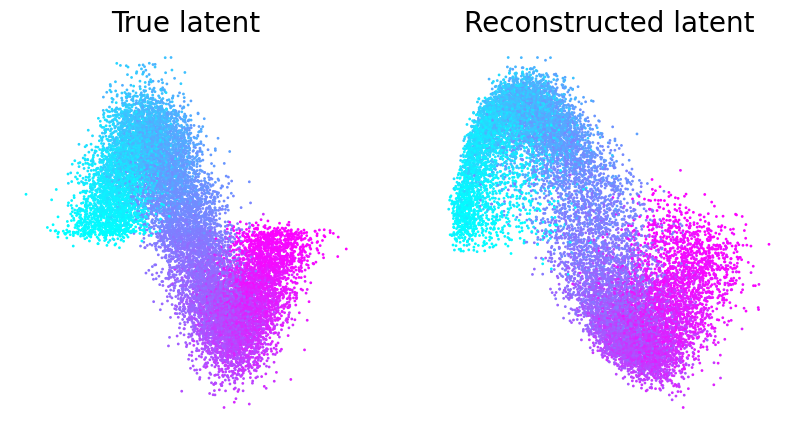

In [4]:
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
ax1.scatter(
    synthetic_viz["true"][:, 0],
    synthetic_viz["true"][:, 1],
    s=1,
    c=synthetic_viz["label"],
    cmap="cool",
)
ax1.axis("off")
ax1.set_title("True latent", fontsize=20)
ax2 = plt.subplot(122)
ax2.axis("off")
ax2.set_title("Reconstructed latent", fontsize=20)
ax2.scatter(
    synthetic_viz["cebra"][:, 0],
    synthetic_viz["cebra"][:, 1],
    s=1,
    c=synthetic_viz["label"],
    cmap="cool",
)

## Figure 1b (right)

- The orange line is median and each black dot is an individual run (n=100). CEBRA-Behavior shows significantly higher reconstruction score compare to pi-VAE, tSNE and UMAP (one-way ANOVA, F(3, 396)=278.31, p<0.00001 with Post Hoc Tukey HSD p<0.0001)

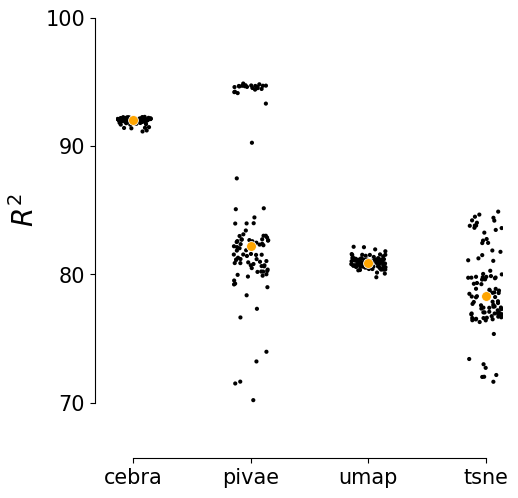

In [5]:
plt.figure(figsize=(5, 5))
ax = plt.subplot(111)

df = pd.DataFrame(synthetic_scores)
sns.stripplot(data=df * 100, color="black", s=3, zorder=1, jitter=0.15)
sns.scatterplot(data=df.median() * 100, color="orange", s=50)
plt.xticks([0, 1, 2, 3], list(synthetic_scores.keys()), fontsize=20, rotation=45)
plt.ylabel("$R^2$", fontsize=20)
plt.yticks(
    np.linspace(0, 100, 11, dtype=int), np.linspace(0, 100, 11, dtype=int), fontsize=20
)
plt.ylim(70, 100)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=15)
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "left": 15},
)

## Figure 1d

- We benchmarked CEBRA against conv-pi-VAE (both with labels and without (self-supervised mode)), tSNE, and unsupervised UMAP. Note, for performance against the original pi-VAE see Extended Data Fig. 1. We plot the 3 latents (note, all CEBRA embedding figures show the first 3 latents).

- The dimensionality (D) of the latent space is set to the minimum and equivalent dimension per method (3D for CEBRA and 2D for others) to fairly compare. Note, higher dimensions for CEBRA can give higher consistency values (see Fig. 4).

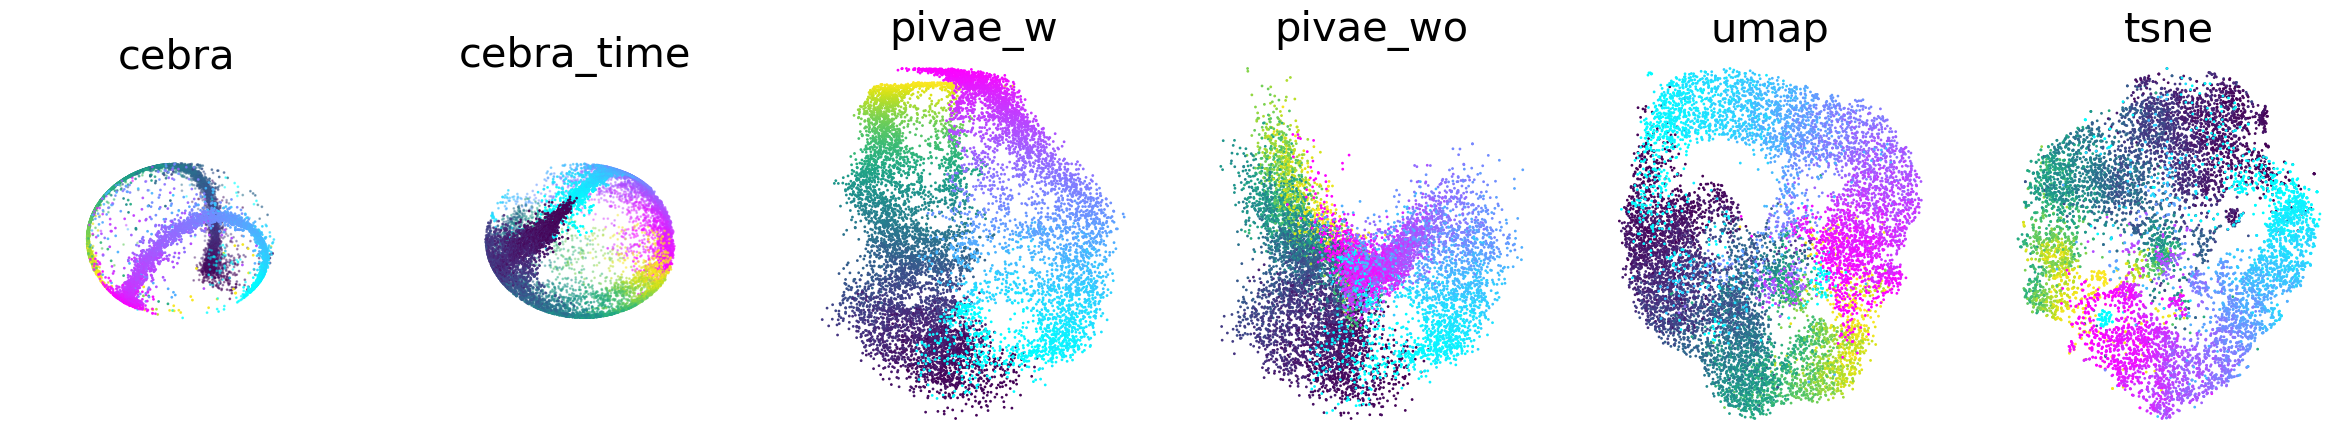

In [6]:
label = viz["label"]
r_ind = label[:, 1] == 1
l_ind = label[:, 2] == 1

fig = plt.figure(figsize=(30, 5))
for i, k in enumerate(["cebra", "cebra_time", "pivae_w", "pivae_wo", "umap", "tsne"]):

    fs = viz[k]
    if not "cebra" in k:
        ax = plt.subplot(1, 6, i + 1)
        ax.scatter(fs[r_ind, 1], fs[r_ind, 0], c=label[r_ind, 0], cmap="viridis", s=1)
        ax.scatter(fs[l_ind, 1], fs[l_ind, 0], c=label[l_ind, 0], cmap="cool", s=1)
        ax.axis("off")
    else:
        ax = plt.subplot(1, 6, i + 1, projection="3d")
        ax.scatter(
            fs[l_ind, 0],
            fs[l_ind, 1],
            fs[l_ind, 2],
            c=label[l_ind, 0],
            cmap="cool",
            s=1,
        )
        ax.scatter(
            fs[r_ind, 0],
            fs[r_ind, 1],
            fs[r_ind, 2],
            c=label[r_ind, 0],
            cmap="viridis",
            s=1,
        )
        ax.axis("off")
    ax.set_title(f"{k}", fontsize=30)

## Figure 1e

- Correlation matrices depict the $R^2$ after fitting a linear model between behavior-aligned embeddings of two animals, one as the target one as the source (mean, n=10 runs). Parameters were picked by optimizing average run consistency across rats.

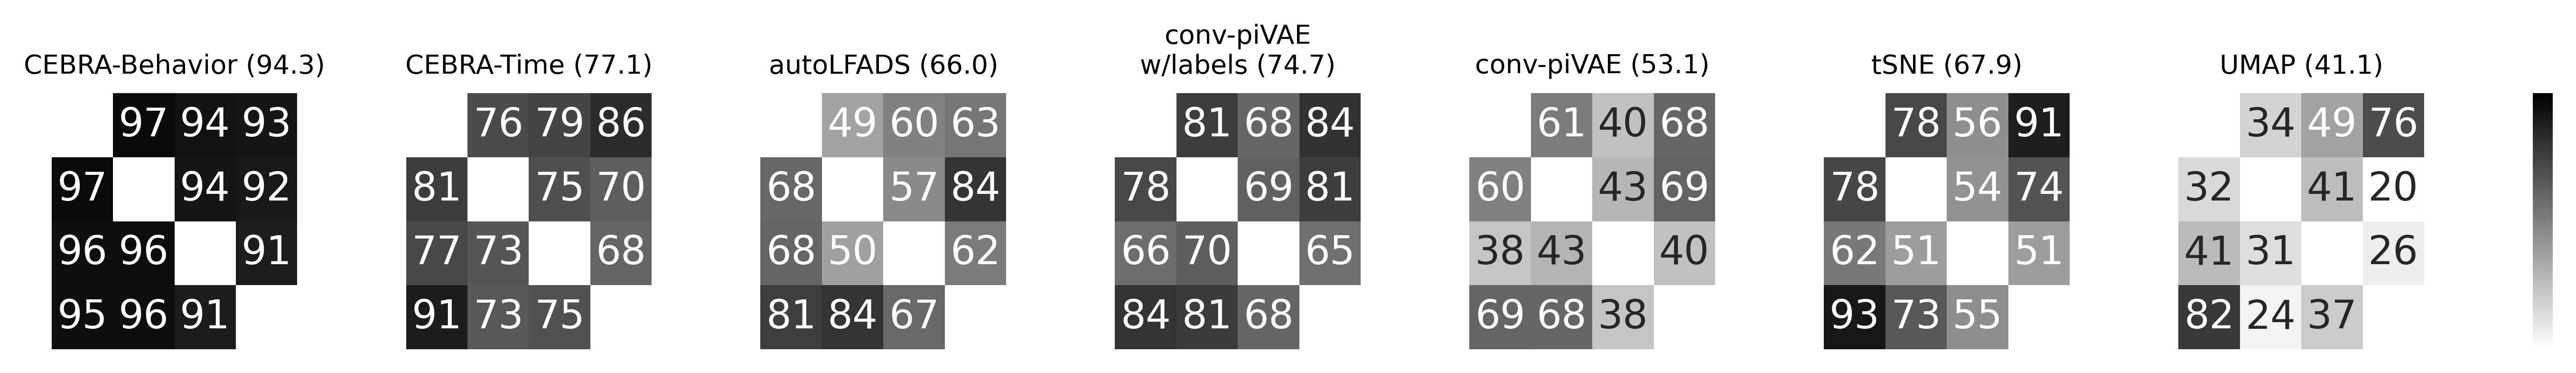

In [7]:
ROOT = pathlib.Path("../data")


def recover_python_datatypes(element):
    if isinstance(element, str):
        if element.startswith("[") and element.endswith("]"):
            if "," in element:
                element = np.fromstring(element[1:-1], dtype=float, sep=",")
            else:
                element = np.fromstring(element[1:-1], dtype=float, sep=" ")
    return element


def load_results(result_name):
    """Load a result file.

    The first line in the result files specify the index columns,
    the following lines are a CSV formatted file containing the
    numerical results.
    """
    results = {}
    for result_csv in (ROOT / result_name).glob("*.csv"):
        with open(result_csv) as fh:
            index_names = fh.readline().strip().split(",")
            df = pd.read_csv(fh).set_index(index_names)
            df = df.applymap(recover_python_datatypes)
            results[result_csv.stem] = df
    return results


results = load_results(result_name="results_v3")


def to_cfm(values):
    values = np.concatenate(values)
    assert len(values) == 12, len(values)
    c = np.zeros((4, 4))
    c[:] = float("nan")
    c[np.eye(4) == 0] = values
    return c


def plot_confusion_matrices(results_best):
    fig, axs = plt.subplots(
        ncols=8,
        nrows=1,
        figsize=(8*1.7, 1.4),
        gridspec_kw={"width_ratios": [1,1,1,1,1,1,1, 0.08]},
        dpi=500,
    )

    last_ax = axs[-1]

    for ax in axs:
        ax.axis("off")

    result_names = [
        ("cebra-10-b", "CEBRA-Behavior"),
        ("cebra-10-t", "CEBRA-Time"),
        ("autolfads", "autoLFADS"),
        ("pivae-10-w", "conv-piVAE\nw/labels"),
        ("pivae-10-wo", "conv-piVAE"),
        ("tsne", "tSNE"),
        ("umap", "UMAP"),
    ]

    for ax, (key, name) in zip(axs[:-1], result_names):

        if name == "autoLFADS":
          cfm = np.array([[       0, 0.49333152, 0.5963056 , 0.62840041],
                 [0.67670133,        0, 0.56677866, 0.83523945],
                 [0.68300837, 0.50128264,        0, 0.61765745],
                 [0.80552981, 0.8398267 , 0.67440838,        0]]
          )
          cfm[np.eye(4) > 0] = float("nan")
        else:
          log = results_best[key]
          cfm = log.pivot_table(
              "train", index=log.index.names, columns=["animal"], aggfunc="mean"
          ).apply(to_cfm, axis=1)
          (cfm,) = cfm.values

        sns.heatmap(
            data=np.minimum(cfm * 100, 99),
            vmin=20,
            vmax=100,
            xticklabels=[],
            yticklabels=[],
            cmap=sns.color_palette("gray_r", as_cmap=True),
            annot=True,
            annot_kws={"fontsize": 12},
            cbar=True if (ax == axs[-2]) else False,
            cbar_ax=last_ax if (ax == axs[-2]) else None,
            ax=ax,
        )
        ax.set_title(f"{name} ({100*np.nanmean(cfm):.1f})", fontsize=8)
    return fig


plot_confusion_matrices(results)
plt.subplots_adjust(wspace = .5)
plt.show()